<a href="https://colab.research.google.com/github/lehai-ml/Workshop_AI/blob/master/Machine_Learning_Workshop_Creating_dogs_images_with_Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Workshop: Creating fake images with Generative Adversarial Network**

*Instructor: Hai Le (le.hai @ kcl.ac.uk)*

**TL;DR**: GAN is composed of two networks, the job of the first one (Generator) is to generate new images, and the job of the second (Discriminator) one is to classify if the images are fake or real. The goal of the Generator is to fool the Discriminator, and the goal of the Discriminator is to catch the Generator.

For the original paper please read [Ian Goodfellows et al., 2014](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

To learn more about the GANs and other Generative models, see the introductory [MIT Deep Generative Modeling Lecture](https://www.youtube.com/watch?v=rZufA635dq4&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=4)

This workshop was modified from the following [tutorial](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

# **Intuition**

**Why do we want to create artificial (fake) instances?**

*   Dimensionality reduction: maybe our data has too many noise, and we want only the most important information (latent variables) of the image.
*   To reduce bias in our dataset. Imagine cases where your dataset is imbalance and is overrepresented by one ethnic group of people.
*   Increase our sample size









![](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-1-4842-3679-6_8/MediaObjects/463582_1_En_8_Fig1_HTML.jpg)


---



---



Essentially, you have a Generator (*G*), which aims to mimic/imitate the real data as close as possible, and a Discriminator (*D*), which aims to distinguish the real from the imitated data. 

Let's look at an overview of the training process, in the first iteration:

1. The *G* generates a random noise image.
2. The *D* receives the random noise image and the real data.
3. The *D* is trained to classify the images into fake vs. real (let's say with logistic regression, to output the probability of real images)
4. The training is backpropagated to *G* which now changes its weight in the network.
5. The *G* now generates a new image.
6. The process is repeat.

**How should my Generator and Discriminator look like?**

You should experiment with different architecture. For example, a recent [Karras et al., 2018](https://arxiv.org/pdf/1710.10196.pdf) paper shows that you could grow both generator and discriminator progressively, as this will increease the fine details as training progresses. 

Here is the output in their paper:

![](https://pbs.twimg.com/media/DXbRSfLWkAA82ZJ.jpg)


# **Data Description**

We will use CIFAR dataset which contains 60 000 images of 10 classes: **airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks**. Each class is of 6000 images and each image is **32 x 32** pixels coloured photographs.

In [23]:
#loading the cifar10 dataset with keras
from keras.datasets.cifar10 import load_data
import numpy as np
#calling the load_data() will return two tuples, which we can organise into training and testing dataset
(trainX,trainy),(testX,testy)=load_data()

Let's look at some images using matplotlib library.

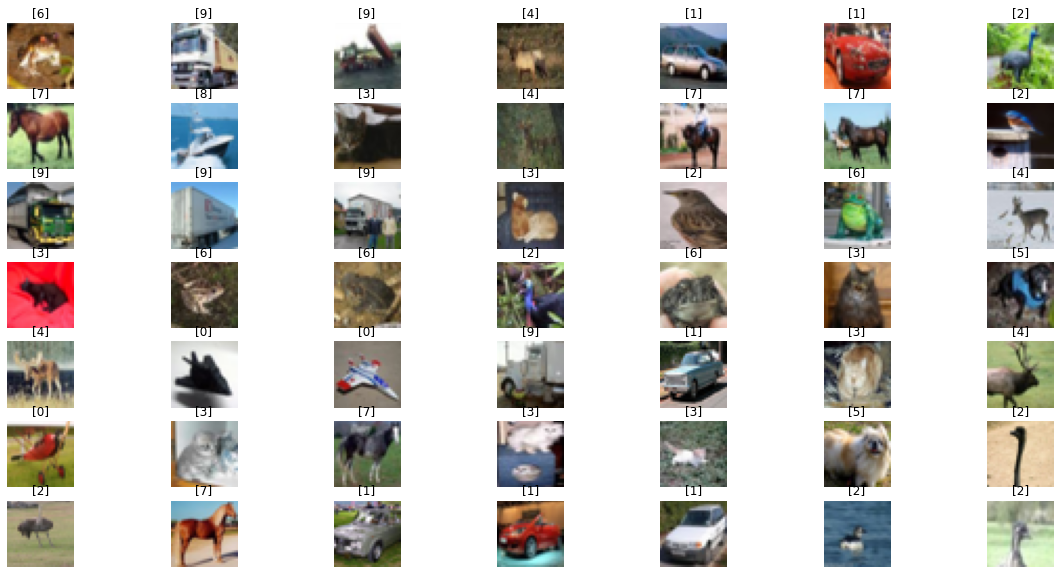

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
for i in range(49):
  plt.subplot(7,7,i+1)
  plt.gca().title.set_text(str(trainy[i]))
  plt.axis('off')
  plt.imshow(trainX[i])
plt.show()

As you can see, the index label for dogs is 5, so let's pick out only the dogs, so we can play with it.

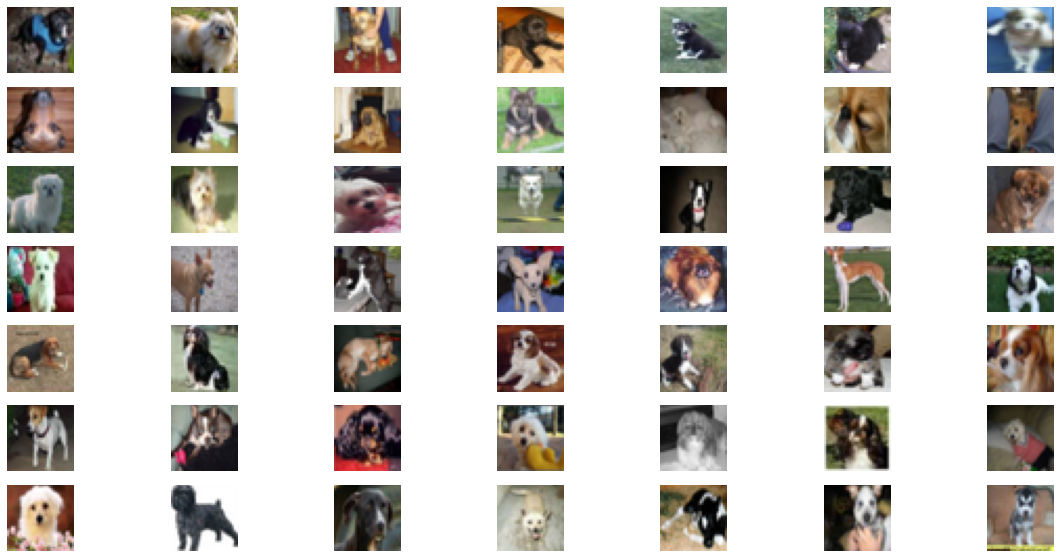

In [24]:
trainX=trainX[np.where(trainy==5)[0]]
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(trainX[i])
plt.show()

#**Discriminator**: Define and Train

The **input** to our Discriminator is a tensor of size 32 x 32 x 3. And the **output** is a binary classification of "*real* (i.e. image from CIFAR)" or "fake (i.e. image generated by Generator)

The discriminator really is a conventional convolutional neural network (CNN). You could use transfer learning like we did in the previous workshop, just remember to define the input and output properly. Otherwise, you could use the following model:

We use ***three convolutional layers***, using a stride 2x2 to downsample the input image. It also uses ***sigmoid activation function*** and mimize with ***binary cross entropy loss function***. We also use LeakyReLu, Dropout, and Adam stochastic gradient descent with learning rate of 0.0002.

In [29]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense,Conv2D,Flatten,Dropout,LeakyReLU
from keras.utils.vis_utils import plot_model

def discriminator(input_shape=(32,32,3)):
  model=Sequential()
  model.add(Conv2D(64,(3,3), padding='same',input_shape=input_shape))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(128,(3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(128,(3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(256,(3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))
  #compile model
  opt=Adam(lr=0.0002,beta_1=0.5)#learning rate= 0.0002 and momentum=0.5 with Adam optimizer
  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
  return model

Let's look at the architecture of this model

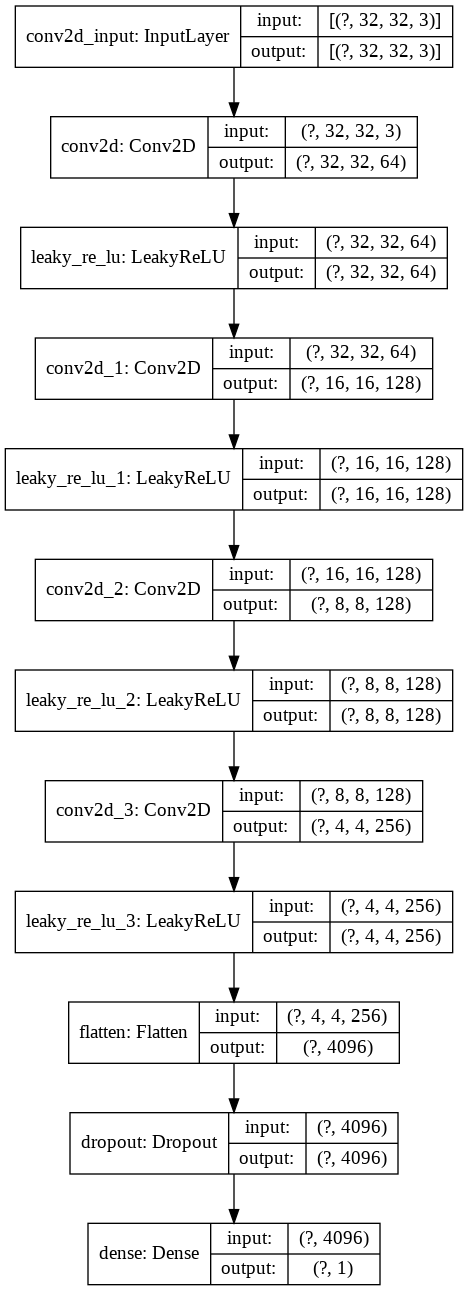

In [30]:
#define model
Discriminator=discriminator()
#summarize the model
plot_model(Discriminator,show_shapes=True,show_layer_names=True)

As you can see we downsample from 32x32x3 to 16x16 then to 8x8 then to 4x4 and so on until it makes the final decision. The generative model will have similar shape but in the reverse order.


Now lets think about how the discriminator will take in the data. Since it will take in the data from both the generator and the real dataset, and we know that the generator will uses ***tanh function*** to generate a tensor with value between [-1,1] (this is because this activation function works well with generator model), we need to change the real samples data accordingly.

In [25]:
def load_real_samples():
  #load cifar10 dataset
  (trainX, trainy), (_,_)=load_data()
  trainX=trainX[np.where(trainy==5)[0]]#pick out only dogs
  X=trainX.astype('float32')
  #scale from [0,255] to [-1,1]
  X=(X-127.5)/127.5
  return X

Next we need to create a training dataset for our discriminator model. This means we will sample some data from the real dataset, and generate some fake data. We also need to attach class label (fake vs. real) to the training dataset.

In [26]:
import numpy as np

def generate_real_samples(dataset,n_samples):
  '''This will take the training set as an argument, 
  and will select random subsample of the images,
  it will also return the class labels of 1 to indicate real images'''
  ix=np.random.randint(0,dataset.shape[0],n_samples)#choose random indices
  X=dataset[ix]
  y=np.ones((n_samples,1))#these are the class labels (1)
  return X, y

def generate_fake_samples(n_samples):
  X=np.random.rand(32*32*3*n_samples)# will create uniform random numbers in [0,1]
  X=-1+X*2 #this will update to have the range [-1,1]
  X=X.reshape(n_samples,32,32,3)#reshape the vector to have the same shape as the input
  y=np.zeros((n_samples,1))#these are labeled as 0
  return X,y



Finally, we can define our train discriminator. We will train our discriminator in batches of 128 images (64 real and 64 fakes). We will train the discriminator with 64 real images first, then with 64 fakes images next, and output accuracies for both at the end. After each iteration, we will take the next 128 images, and so on for 20 runs.

In [27]:
def train_discriminator(model,dataset,n_iter=20,n_batch=128):
  '''This will trains the discriminator first with real images (64 images),
  and then trains with fake images (64 images) and prints out the accuracy after each iteration'''
  half_batch=int(n_batch/2)
  for i in range(n_iter):
    X_real,y_real=generate_real_samples(dataset,half_batch)
    _,real_acc=model.train_on_batch(X_real,y_real)#the general syntax for Keras is model.train
    X_fake,y_fake=generate_fake_samples(half_batch)
    _,fake_acc=model.train_on_batch(X_fake,y_fake)
    print('>%d real=%.0f%% fake=%.0f%%'% (i+1,real_acc*100,fake_acc*100))

Putting everything together, we now run the function to see how well our Discriminator model has learnt


In [31]:
train_discriminator(Discriminator,dataset=load_real_samples())

>1 real=64% fake=0%
>2 real=98% fake=0%
>3 real=98% fake=8%
>4 real=94% fake=50%
>5 real=94% fake=84%
>6 real=94% fake=100%
>7 real=94% fake=100%
>8 real=89% fake=100%
>9 real=94% fake=100%
>10 real=94% fake=100%
>11 real=97% fake=100%
>12 real=98% fake=100%
>13 real=100% fake=100%
>14 real=100% fake=100%
>15 real=98% fake=100%
>16 real=98% fake=100%
>17 real=98% fake=100%
>18 real=100% fake=100%
>19 real=98% fake=100%
>20 real=100% fake=100%


Now we know how to train the discriminator, let's now look at how to create the generator model.

# **Generator**: Define

The **input** to the generator will be an arbitrarily defined vector space of Gaussian- distributed values. The **output** will be a 32 x 32 x 3 tensor with values [-1,1]

However, remember that the defined **latent space** has **no meaning**. The generator will take points from that space, and assign meaning to them so that at the very end of the training, the latent vector space represents a **compressed representation of the output space**, that **only the generator** will know how to turn into CIFAR-10 images.

Think of the latent space as a **white piece of paper**, and the generator as the folding **instruction** to create a paper origami. This piece of paper has no meaning or inherent value, but only with the trained generator it can become a paper swan.

As you remember in our previous [image style transfer workshop](https://github.com/lehai-ml/Workshop_AI/blob/master/Machine_Learning_Workshop_2_Image_Style_Transfer.ipynb), there is something called **feature map**, that can be extracted from CNN. Essentially, at the lower level of the network, the CNN learns the fine details of the image (e.g. pixel values), but at higher level, it learns the low resolution features of the image (e.g., contours and textures). Because our generator is an inverted model of the CNN, the first layer of the model need to represent the **low-level features** (i.e. the essence) of the output image. From here, the layers will be upsampled, and further refined so the model can generate the fine details of the image.


In [32]:
from keras.layers import Conv2DTranspose,Reshape

def generator(latent_dim):
  model=Sequential()
  #we start off with 4x4 images
  n_nodes=256*4*4
  model.add(Dense(n_nodes, input_dim=latent_dim))#we allow for 256 of such low-level features
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))
  #upsample to 8x8
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #upsample to 16x16
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #upsample to 32x32
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #output layer
  model.add(Conv2D(3,(3,3), activation='tanh', padding='same'))
  return model

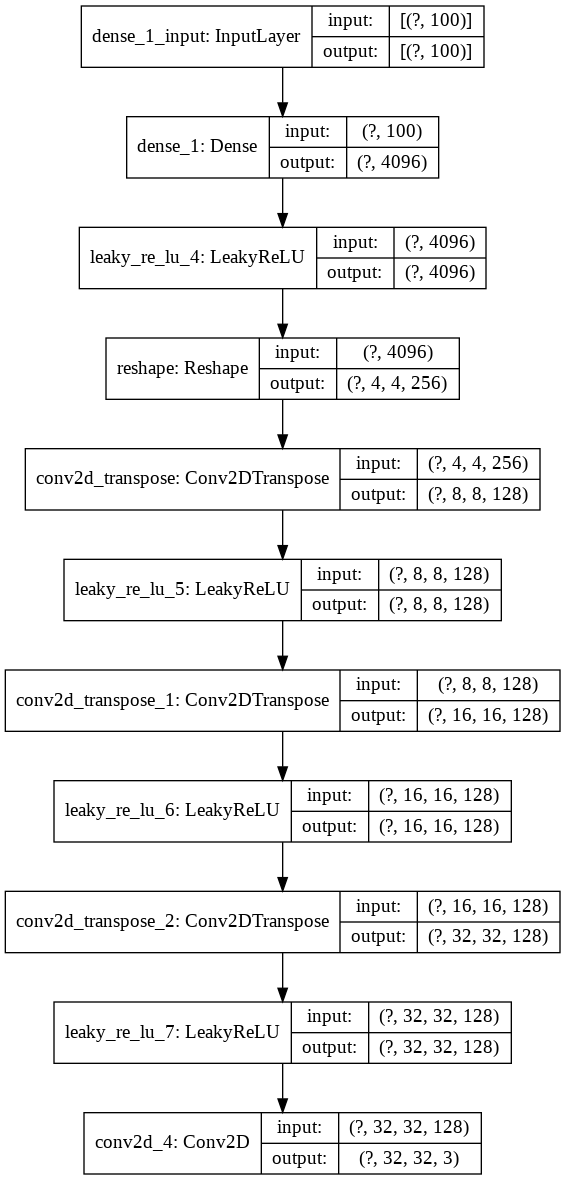

In [33]:
Generator=generator(latent_dim=100)
plot_model(Generator,show_shapes=True,show_layer_names=True)

Let's see how we can generate new images with the generator

In [34]:
def generate_latent_points(latent_dim,n_samples):
  x_input=np.random.randn(latent_dim*n_samples)#this will draws from the standard Gaussian
  #reshape into a batch of inputs for the network
  x_input=x_input.reshape(n_samples,latent_dim)
  return x_input

Now let's update our some fake samples function from above

In [35]:
def generate_fake_samples(generator_model,latent_dim,n_samples):
  x_input=generate_latent_points(latent_dim,n_samples)
  X=generator_model.predict(x_input)
  y=np.zeros((n_samples,1))
  return X,y

Let's generate a few fake samples with our generator and see how it behaves with matplotlib

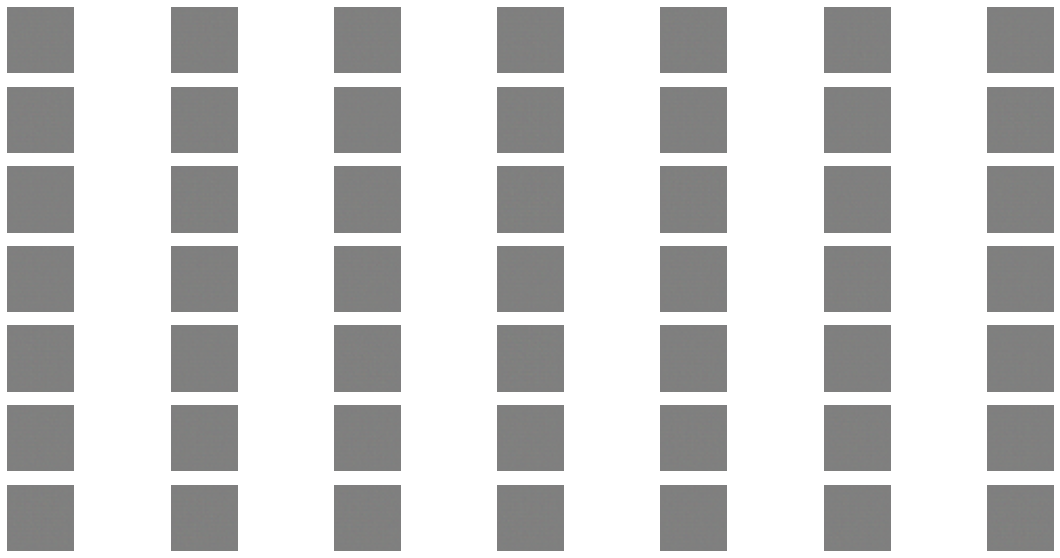

In [36]:
X, _=generate_fake_samples(Generator,latent_dim=100,n_samples=49)
X=(X+1)/2.0 #We need to scale pixel values from [-1,1] to [0,1]
plt.figure(figsize=(20,10))
for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X[i])
  #show the figure
plt.show()
  

As you can see, this is exactly what we want from the untrained generator model. It is nothing but random noise.

# **Combined model Training**

**How should the generator be trained?**

It should be trained based on the performance of the discriminator (i.e. if the performance of the discriminator is bad, then the generator is updated less, if the performance of the discrimator is good, then the generator needs to update more often)

To correctly link the performance of the discriminator with the generator, we could stack them together like in the Figure shown above (Lets call this a GAN model). The generator take input from the latent space, and feeds to the discriminator along with the real dataset. The output performance from the discriminator is then used to train the generator.

Finally, when training the generator via this GAN model, we want the discriminator to think that the samples output by the generator are **real**. Therefore, when generator is trained as part of the GAN model, the generated samples will have label as **real** (class 1)

**Why would we want to do this?**

When the discriminator sees a fake image and correctly predicts it as fake, but because the image is labelled as real, the penalty will be high (because we did not managed to fool the discriminator), and the backpropagation will changes the weights of the generator (the weights of the discriminator is already set to untrainable).



Here is the **overview** of the training process of the GAN model:

1. The *Discriminator* is trained with outputs from *Generator* (labelled as 'fake') and real samples (labelled as 'real') as shown in the `train_discriminator` function above and the Discriminator's weights are adjusted accordingly.
2. The *Discriminator* layer is frozen (i.e. untraineable) and now the *GAN model* is run again. Here, the inputs to the *Discriminator* is real samples (labelled as '**real**') **and** outputs from the *Generator* (**also** labelled as '**real**') (read above for reason why). The backpropagation will adjust the weights of the *Generator*
3. This process is repeated.


Let's create a combined model

In [37]:
def combined_gan(generator_model,discriminator_model):
  discriminator_model.trainable=False#the weights are not trainable
  model=Sequential()
  model.add(generator_model)
  model.add(discriminator_model)
  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

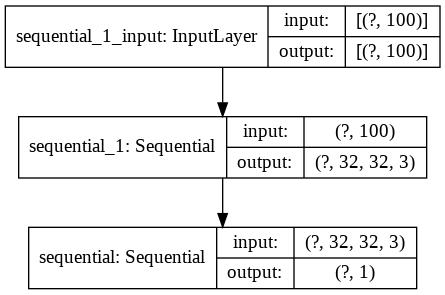

In [38]:
gan_model=combined_gan(Generator,Discriminator)
plot_model(gan_model,show_shapes=True,show_layer_names=True)

**Let's recap:**


* We need to first update the discriminator model with real and fake samples, then update the generator via the combined model.

* The number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset of 50K samples, so we have 390 batches per epoch. 

* The discriminator is updated twice per batched, once with the real samples and once with fake samples.

In [39]:
def train(generator_model,discriminator_model,gan_model,dataset,latent_dim,n_epochs=200,
          n_batch=128):
  batch_per_epoch=int(dataset.shape[0]/n_batch)
  half_batch=int(n_batch/2)

  for i in range(n_epochs):
    for j in range(batch_per_epoch):
      #get randomly selected 'real' samples from CIFAR-10:
      X_real,y_real=generate_real_samples(dataset,half_batch)
      #update discriminator model
      discriminator_loss_1,_=discriminator_model.train_on_batch(X_real,y_real)
      #generate 'fake' samples:
      X_fake,y_fake=generate_fake_samples(generator_model,latent_dim,half_batch)
      discriminator_loss_2,_=discriminator_model.train_on_batch(X_fake,y_fake)
      #prepare points in latent space as input for the generator
      X_gan=generate_latent_points(latent_dim,n_batch)
      y_gan=np.ones((n_batch,1))
      #update the generator via the discriminator's error
      gan_loss=gan_model.train_on_batch(X_gan,y_gan)
      #summarize losses on this batch
      print('>%d,%d/%d, d1=%.3f, d2=%.3f,g=%.3f'% (i+1,j+1,
                                                   batch_per_epoch,discriminator_loss_1,
                                                   discriminator_loss_2,gan_loss))
      



# **Evaluate GAN model**

There is **no objective way** to calculate the score or performance of the GAN model.

You could also imagine the case when you see the fake images are "good enough", the quality of images may vary and can degrade if you train further.

You could however:
1. Periodically evaluate the classification accuracy of the discriminator
2. Periodically generate images and save them to file for human review.
3. Periodically save the generator model.

In [58]:
def save_plot(examples,epoch,n=7):
  examples=(examples+1)/2.0
  plt.figure(figsize=(20,10))
  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.axis('off')
    plt.imshow(examples[i])
  filename='generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.close()

def summarize_performance(epoch,generator_model,discriminator_model,
                          dataset,latent_dim,n_samples=150):
  '''We could add this to the train function to check periodically after every 10th epochs'''

  X_real,y_real=generate_real_samples(dataset,n_samples)
  _,acc_real=discriminator_model.evaluate(X_real,y_real,verbose=0)
  #prepare fake samples
  X_fake,y_fake=generate_fake_samples(generator_model,latent_dim,n_samples)
  _,acc_fake=discriminator_model.evaluate(X_fake,y_fake,verbose=0)
  print('>Accuracy real: %.0f%%, fake: %.0f%%'% (acc_real*100,acc_fake*100))
  #save plot
  save_plot(X_fake,epoch)
  #save the generator model to file
  filename='generator_model_%03d.h5'%(epoch+1)
  generator_model.save(filename)


We can put this together in the train function above and run:

In [65]:
def train(generator_model,discriminator_model,gan_model,dataset,latent_dim,n_epochs=200,
          n_batch=128):
  batch_per_epoch=int(dataset.shape[0]/n_batch)
  half_batch=int(n_batch/2)

  for i in range(n_epochs):
    for j in range(batch_per_epoch):
      #get randomly selected 'real' samples from CIFAR-10:
      X_real,y_real=generate_real_samples(dataset,half_batch)
      #update discriminator model
      discriminator_loss_1,_=discriminator_model.train_on_batch(X_real,y_real)
      #generate 'fake' samples:
      X_fake,y_fake=generate_fake_samples(generator_model,latent_dim,half_batch)
      discriminator_loss_2,_=discriminator_model.train_on_batch(X_fake,y_fake)
      #prepare points in latent space as input for the generator
      X_gan=generate_latent_points(latent_dim,n_batch)
      y_gan=np.ones((n_batch,1))
      #update the generator via the discriminator's error
      gan_loss=gan_model.train_on_batch(X_gan,y_gan)
      #summarize losses on this batch
      print('>%d,%d/%d, d1=%.3f, d2=%.3f,g=%.3f'% (i+1,j+1,
                                                   batch_per_epoch,discriminator_loss_1,
                                                   discriminator_loss_2,gan_loss))
      #to evaluate the model performance, periodically
      
    if (i+1)%10==0:
      summarize_performance(i,generator_model,discriminator_model,dataset,latent_dim)
        

Let's see if this works. Make sure you are running on GPU, as with CPU will take hours.

# **Execution and saving models**

In [66]:
latent_dim=100
Generator=generator(latent_dim)
Discriminator=discriminator()
gan_model=combined_gan(Generator,Discriminator)
dataset=load_real_samples()
#train model
train(Generator,Discriminator,gan_model,dataset,latent_dim)

Streaming output truncated to the last 5000 lines.
>73,7/39, d1=0.842, d2=0.215,g=2.364
>73,8/39, d1=0.528, d2=0.231,g=2.099
>73,9/39, d1=0.488, d2=0.403,g=1.744
>73,10/39, d1=0.365, d2=0.429,g=1.457
>73,11/39, d1=0.573, d2=0.666,g=1.305
>73,12/39, d1=0.454, d2=0.652,g=1.213
>73,13/39, d1=0.528, d2=0.812,g=1.181
>73,14/39, d1=0.764, d2=0.643,g=1.238
>73,15/39, d1=0.774, d2=0.451,g=1.193
>73,16/39, d1=0.738, d2=0.523,g=1.260
>73,17/39, d1=0.699, d2=0.436,g=1.383
>73,18/39, d1=0.619, d2=0.445,g=1.302
>73,19/39, d1=0.621, d2=0.430,g=1.253
>73,20/39, d1=0.564, d2=0.474,g=1.275
>73,21/39, d1=0.542, d2=0.551,g=1.231
>73,22/39, d1=0.557, d2=0.554,g=1.237
>73,23/39, d1=0.537, d2=0.550,g=1.251
>73,24/39, d1=0.638, d2=0.534,g=1.216
>73,25/39, d1=0.606, d2=0.600,g=1.216
>73,26/39, d1=0.628, d2=0.524,g=1.238
>73,27/39, d1=0.561, d2=0.449,g=1.360
>73,28/39, d1=0.547, d2=0.525,g=1.316
>73,29/39, d1=0.536, d2=0.489,g=1.267
>73,30/39, d1=0.526, d2=0.535,g=1.345
>73,31/39, d1=0.568, d2=0.463,g=1.459
>7

Here I got to the accuracy of 65% for real, and fake at 81%. Not the best, let's examine some of our results:

Here is what the model saw at **epoch 20**
![](https://github.com/lehai-ml/Workshop_AI/blob/master/GAN_images/generated_plot_e020.png?raw=true)

**epoch 50**

![](https://github.com/lehai-ml/Workshop_AI/blob/master/GAN_images/generated_plot_e050.png?raw=true)

**epoch 100**
![](https://github.com/lehai-ml/Workshop_AI/blob/master/GAN_images/generated_plot_e100.png?raw=true)

**epoch 150**
![](https://github.com/lehai-ml/Workshop_AI/blob/master/GAN_images/generated_plot_e150.png?raw=true)

**epoch 200**
![](https://github.com/lehai-ml/Workshop_AI/blob/master/GAN_images/generated_plot_e200.png?raw=true)


As you can see there is definitely an improvement in the model as it is training longer. Can you spot a dog in the images from the epoch 200?

# **Loading the trained model and generate new images**

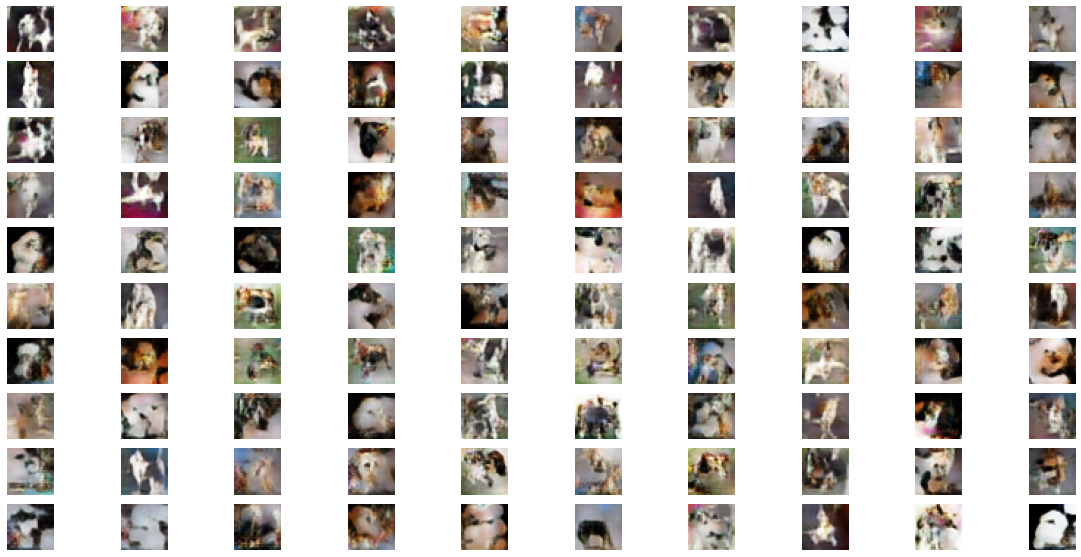

In [67]:
from keras.models import load_model

def create_plot(examples,n):
  plt.figure(figsize=(20,10))
  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.axis('off')
    plt.imshow(examples[i,:,:])
  plt.show()

#load model
model=load_model('generator_model_200.h5')
latent_points=generate_latent_points(100,100)
#generate images
X=model.predict(latent_points)
X=(X+1)/2.0
#plot the result
create_plot(X,10)

I can see this dog is sitting, it has a big black nose, eyes and ears. Keep in mind that none of the dogs are real :)))

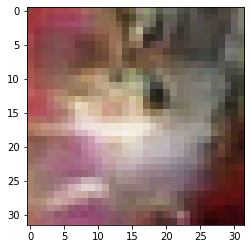

In [76]:
plt.imshow(X[8])

I think the model has nailed the fact that the dogs have nose and eyes. That is pretty cool

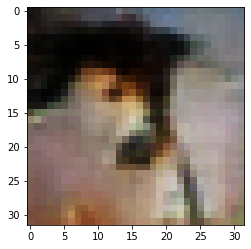

In [85]:
plt.imshow(X[19])

# **Summary:**

In this tutorial, you have learnt how to create GAN from scratch. Here are the take home messages:

1. GAN is composed of the Discriminator and Generator, who are playing a zero-sum game, each tries to outsmart the other.
2. You train the Discriminator separately from the Generator, but the Generator is trained based on the performance of the Discriminator. (Bit counterintuitive but try to understand why we had to freeze the layers of the Discriminator when we are training the Generator)


Knowing this can you create a GAN to generate cats?